In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import tdgl
from tdgl.geometry import box, circle
from tdgl.visualization.animate import create_animation

In [28]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
from IPython.display import HTML, display

In [29]:
#定义视频函数
def make_video_from_solution(
    solution,
    quantities=("order_parameter"),
    fps=20,
    figsize=(5, 4),
):
    """Generates an HTML5 video from a tdgl.Solution."""
    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation(
                h5file,
                quantities=quantities,
                fps=fps,
                figure_kwargs=dict(figsize=figsize),
            )
            video = anim.to_html5_video()
        return HTML(video)

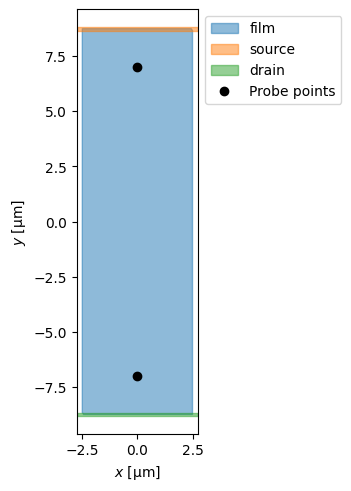

In [30]:
#定义形状和参数
length_units = "um"

# Material parameters
xi = 0.5 #相干长度
london_lambda = 2 #伦敦穿透
d = 0.1 #厚度
layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=1)

# Device geometry
total_width = 5
total_length = 3.5 * total_width
link_width = total_width / 3 #这是什么

# Outer geometry of the film
film = (
    tdgl.Polygon("film", points=box(total_width, total_length))
    .resample(401)
    .buffer(0)
)

# Current terminals
source = (
    tdgl.Polygon("source", points=box(1.1 * total_width, total_length / 100))
    .translate(dy=total_length / 2)
)
drain = source.scale(yfact=-1).set_name("drain")

#  Voltage measurement points
probe_points = [(0, total_length / 2.5), (0, -total_length / 2.5)]

device = tdgl.Device(
    "weak_link",
    layer=layer,
    film=film,
    terminals=[source, drain],
    probe_points=probe_points,
    length_units=length_units,
)

fig, ax = device.draw()

Constructing Voronoi polygons: 100%|██████████| 4931/4931 [00:02<00:00, 1973.04it/s]


num_sites,4931
num_elements,9460
min_edge_length,7.006e-02
max_edge_length,2.379e-01
mean_edge_length,1.459e-01
min_area,2.901e-03
max_area,3.585e-02
mean_area,1.774e-02
coherence_length,5.000e-01
length_units,um


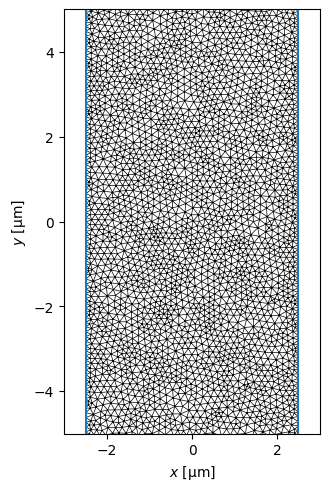

In [31]:
#有限元构造
device.make_mesh(max_edge_length=xi / 2, smooth=100)
fig, ax = device.plot(mesh=True, legend=False)
_ = ax.set_ylim(-5, 5)
device.mesh_stats()

In [141]:
#设置求解参数和外场并求解
options = tdgl.SolverOptions(
    # Allow some time to equilibrate before saving data.
    #skip_time=100, #先热化后模拟
    solve_time=100,
    output_file=os.path.join('solutions', "weak-link-zero-field.h5"),
    #output_file=None,
    field_units = "mT",
    current_units="uA",
    save_every=100,
)

# varying uniform field according to time_factor
from tdgl.sources import VaryingField

def scaling(t, tmin=0, t_up=40, t_down=60, tmax=80, initial=0.0, middle=1.5, final=1.0):
    if t < tmin:
        return initial
    elif tmin <= t < t_up:
        return initial + (middle - initial) * (t - tmin) / (t_up - tmin)
    elif t_up <= t < t_down:
        return middle
    elif t_down <= t < tmax:
        return middle + (final - middle) * (t - t_down) / (tmax - t_down)
    return final

def my_scaling(t, setpoints):
    for time, field in setpoints:
        pass
    pass


applied_vector_potential = (
    VaryingField(0.4, time_factor=scaling, field_units=options.field_units, length_units=device.length_units)
)

zero_current_solution = tdgl.solve(
    device,
    options,
    applied_vector_potential=applied_vector_potential,
)

Output file already exists. Renaming to solutions\weak-link-zero-field-1.h5.
Simulating: 100%|█████████▉| 100/100 [01:35<00:00,  1.04tau/s ]


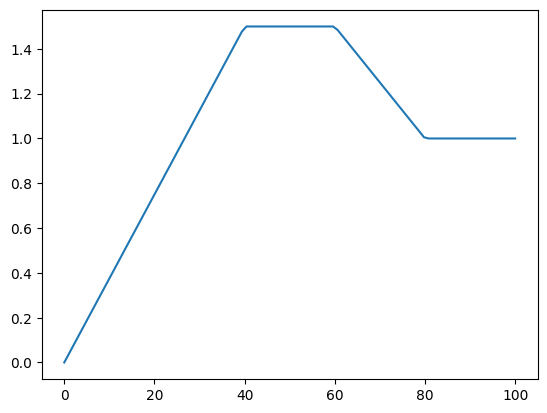

In [142]:
def plot_externel_field(func=lambda t: 1.0, time_range=np.linspace(0,100,100)):
    F = np.zeros_like(time_range)
    for i in range(len(time_range)):
        dt = time_range[i]
        F[i] = func(dt)
    plt.plot(time_range, F)

plot_externel_field(scaling)

In [152]:
time = 60
step = zero_current_solution.closest_solve_step(time)
zero_current_solution.load_tdgl_data(step)
step

128

In [154]:
zero_current_solution.times

array([1.00000000e-06, 1.19627803e-01, 1.86724873e-01, 2.65553197e-01,
       3.58093488e-01, 4.65652373e-01, 5.88323644e-01, 7.25168788e-01,
       8.76241028e-01, 1.04312697e+00, 1.22732644e+00, 1.42829312e+00,
       1.64777915e+00, 1.88654683e+00, 2.14510764e+00, 2.42352849e+00,
       2.72349997e+00, 3.04675102e+00, 3.39376613e+00, 3.76610746e+00,
       4.16457585e+00, 4.59116620e+00, 5.04617000e+00, 5.52957392e+00,
       6.04228455e+00, 6.58392991e+00, 7.15170952e+00, 7.74340818e+00,
       8.35598156e+00, 8.97986780e+00, 9.58169284e+00, 1.01606360e+01,
       1.07201859e+01, 1.12630904e+01, 1.17915653e+01, 1.23074347e+01,
       1.28122275e+01, 1.33072464e+01, 1.37936183e+01, 1.42723320e+01,
       1.47442671e+01, 1.52102162e+01, 1.56709004e+01, 1.61269253e+01,
       1.65788872e+01, 1.70273764e+01, 1.74729597e+01, 1.79161881e+01,
       1.83576047e+01, 1.87977511e+01, 1.92369232e+01, 1.96754542e+01,
       2.01137923e+01, 2.05520859e+01, 2.09908098e+01, 2.14305497e+01,
      

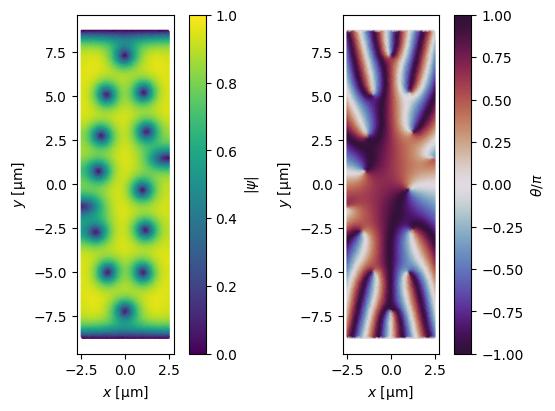

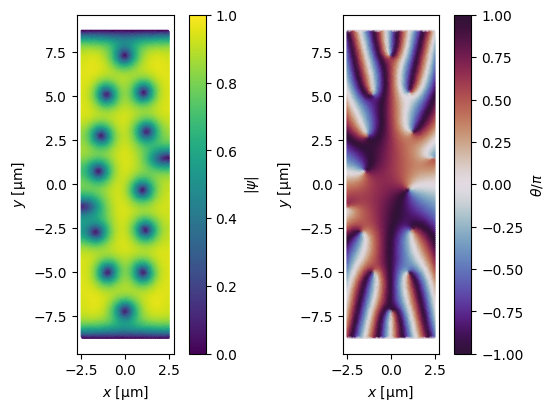

In [165]:
fig, axes = zero_current_solution.plot_order_parameter(figsize=(5.5, 4))

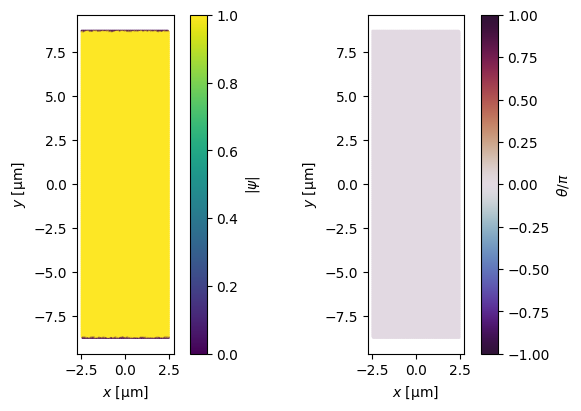

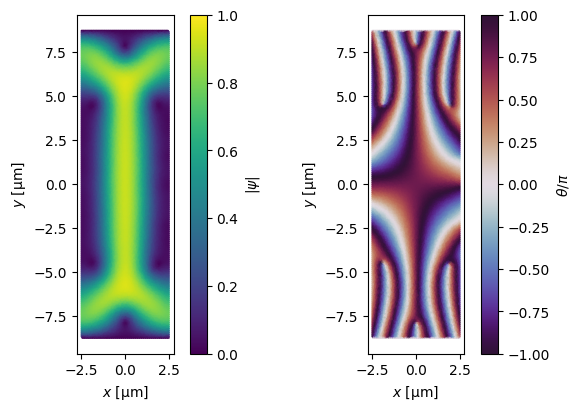

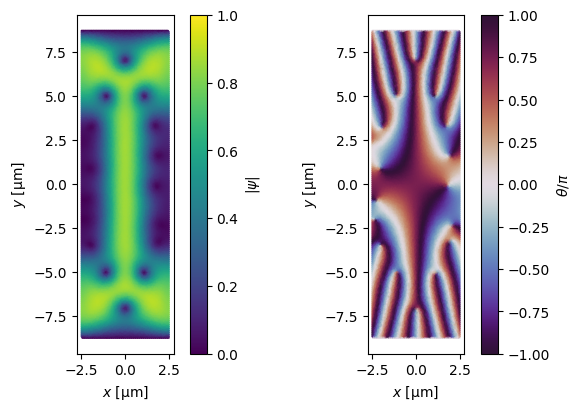

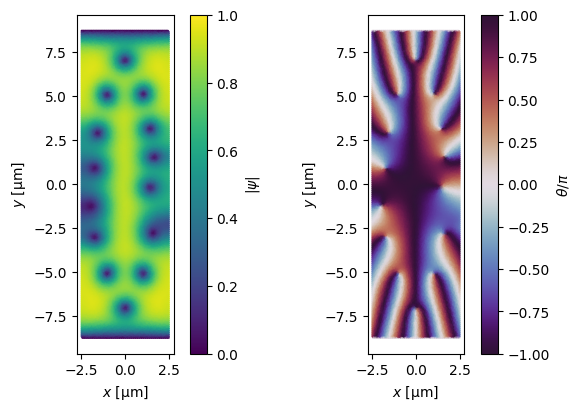

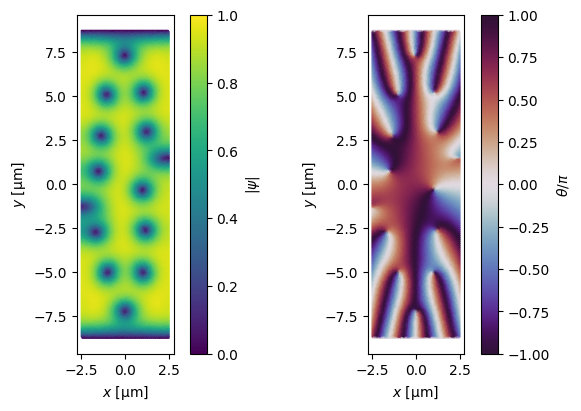

In [173]:
#绘图
def plot_simulations_of_times(solution, setpoints, time_factor):
    for time in setpoints:
        step = solution.closest_solve_step(time)
        solution.load_tdgl_data(step)
        fig, axes = solution.plot_order_parameter(figsize=(6, 4))
        plt.annotate('Time: {exact_time:.1f}s'.format(exact_time = solution.times[step]), xy=(-5,5))
        plt.show()

samples = [0, 40, 60, 80, 100]

plot_simulations_of_times(zero_current_solution, samples, scaling)

In [163]:
zero_field_video = make_video_from_solution(
        zero_current_solution,
        quantities=["order_parameter", "phase", "scalar_potential"],
        figsize=(6.5, 4),
    )
display(zero_field_video)